In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import os
from statistics import mean
from statistics import median

In [2]:
#Main Function to run analysis
def runAnalysis(timePath, lifetimePath, SSPath, trim, minLength):
    time = list(pd.read_csv(timePath, header = None)[0])
    lifetime = list(pd.read_csv(lifetimePath, header = None)[0])
    SS = list(pd.read_csv(SSPath, header = None)[0])
    states = {'state1': [1 if i == 1 else 0 for i in SS], 'state2':[1 if i == 2 else 0 for i in SS], 
              'state3': [1 if i == 3 else 0 for i in SS], 'state4':[1 if i == 4 else 0 for i in SS]}
    stateColors = {'state1': 'green', 'state2':'blue', 
                   'state3': 'red', 'state4':'yellow'}
    print('legend: ')
    print(stateColors)
    print('Raw Data')
    plotData(time, states, lifetime, stateColors, True)
    states_analyzed, stateWindows, timeWindows = stateAnalysis(lifetime, states, time, trim, minLength)
    print('Trimmed Data')
    plotData(time, stateWindows, lifetime, stateColors, False)
    
    
    
    states_analyzed_Formatted = {key:pd.Series(value) for key, value in states_analyzed.items()}
    stateWindows_Formatted = {key:pd.Series(value) for key, value in stateWindows.items()}
    timeWindows_Formatted =  {key:pd.Series(value) for key, value in timeWindows.items() }
    
    nestedDict = {k: {'Lifetime Analysis': states_analyzed_Formatted[k], 'Index': stateWindows_Formatted[k], 'Time': timeWindows_Formatted[k]} for k in timeWindows_Formatted.keys()}
    reformed_dict = {}
    for outerKey, innerDict in nestedDict.items():
        for innerKey, values in innerDict.items():
            reformed_dict[(outerKey,
                           innerKey)] = values
    pd.options.display.max_seq_items = 2000        
    results_df = pd.DataFrame(reformed_dict)

    return results_df

    
#Takes in data, omits epochs too short, trims transition periods, analyzes epochs after trimming. 
def stateAnalysis(lifetime, stateData, time, trim, minLength):
    states_analyzed = {}
    stateWindows = {}
    timeWindows = {}
    for key in stateData:
        analyzedWindows = []
        changes = stateChanges(stateData[key])
        

        #omit epochs too short, analyze windows long enough
        i = 0
        while i < len(changes):
            if time[changes[i][1]]-time[changes[i][0]]<minLength:
                changes.remove(changes[i]) #removing epochs too short
            else:
                #trimming ends of epochs
                changes[i][0] = find_nearest(time, time[changes[i][0]]+trim) 
                changes[i][1] = find_nearest(time, time[changes[i][1]]-trim) 
                #analyzedWindows.append(max_surroundMean(lifetime[changes[i][0]:changes[i][1]], 1))
                if len(lifetime[changes[i][0]:changes[i][1]])>1:
                    analyzedWindows.append(median(lifetime[changes[i][0]:changes[i][1]]))
                i+=1
        states_analyzed[key] = analyzedWindows
        stateWindows[key] = changes
        np.save((path + 'results/' + key + 'test.npy'),changes)
        timeWindows[key] = [[time[i[0]],time[i[1]]] for i in changes]
    return states_analyzed, stateWindows, timeWindows
   
#Takes in a list, finds average of max value and n surrounding data points
def max_surroundMean(data, n):
    maxIDX = data.index(max(data))    
    if maxIDX == 0:
        maxIDX = n
    elif maxIDX == len(data)-1:
        maxIDX = maxIDX-n
    return mean(data[maxIDX-n:maxIDX+n+1])
        
#returns index of closest corresponding value in the array 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
        
#Returns list of pairs (index) [[start, stop], [start, stop]] for all "true" periods
def stateChanges(data):
    currState = data[0]
    if currState:
        temp = [0]
    changes = []
    for i in range(len(data)):
        if data[i] != currState:
            currState = data[i]
            if currState:
                temp = [i]
            else:
                temp.append(i-1)
                changes.append(temp)
        #if you reach the end of the time series
        elif data[i] and i == (len(data)-1):
                temp.append(i)
                changes.append(temp)
        else:
            pass
    
    return changes
    
def plotData(time, states, lifetime, stateColors, rawStates):
    fig, ax1 = plt.subplots(figsize=(200, 10))
    ax1.plot(time, lifetime)
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('Lifetime (ns)')
    for key in states:
        if rawStates:
            changes = stateChanges(states[key])
            for i in changes:
                ax1.axvspan(time[i[0]], time[i[1]], color=stateColors[key], alpha=0.5)
        else:
            for i in states[key]:
                ax1.axvspan(time[i[0]], time[i[1]], color=stateColors[key], alpha=0.5)
            
    plt.show()
    


In [3]:
    #path = '20220214_1610_SW_001_analysis_csv_20220426/'
    #path = '20220219_1610_SW_002_analysis_csv_20220426/'
    #path = '20220301_1612_SW_003_analysis_csv_20220426/'
    #path = '20220302_1611_SW_003_analysis_csv_20220426/'
    #path = '20220304_1630_SW_002_analysis_csv_20220426/'
    #path = '20220312_1629_SW_002_analysis_csv_20220426/'
    #path = '20220313_1626_SW_002_analysis_csv_20220426/'
    #path = '20220314_1610_SW_003_analysis_csv_20220426/'
    #path = '20220315_1612_SW_004_analysis_csv_20220426/'
    #path = '20220316_1611_SW_004_analysis_csv_20220426/'
    #path = '20220317_1627_SW_002_analysis_csv_20220426/'
    
    #path = '20220318_1626_SW_003_analysis_csv_20220426/'
    #path = '20220319_1630_SW_003_analysis_csv_20220426/'
    #path = '20220322_1627_SW_003_analysis_csv_20220426/'
    #path = '20220323_1629_SW_003_analysis_csv_20220426/'
    #path = '20220324_1612_SW_005_analysis_csv_20220426/'
    #path = '20220325_1611_SW_005_analysis_csv_20220426/'
    #path = '20220328_1610_SW_005_analysis_csv_20220426/'
    #path = '20220329_1626_SW_004_analysis_csv_20220426/'
    #path = '20220330_1630_SW_004_analysis_csv_20220426/'
    #path = '20220331_1629_SW_004_analysis_csv_20220426/'
    #path = '20220402_1627_SW_004_analysis_csv_20220426/'
    path = '20220712_PM29_111_Achmut_001_analysis_csv_20220830/'
    path = '/Users/pingchuanma/Desktop/ChenLab_Data/FLP_data_sleep/ACh_mut/20220425_109_AChmut_SW_001_analysis_csv_20220510/'
    
    
    
    
    os.mkdir(path + 'results')

In [4]:
#Parameters
timePath = path + 'time.csv'
lifetimePath = path + 'lft_emp.csv'
statesPath = path + 'states.csv'


trim = 12               #how much to trim from beginning/end of epochs
minLength = 16+(2*trim) #minimum length of epochs to include 
                        #(length before trimming, so if you want 10 secopnds minimum then use 10+(2*trim) as the value)

#Data Returned as a df (results)
#Format:
#    State1                                               State 2...
#    calculated lifetime average    index   time window   calculated lifetime average    index   time
    


In [5]:
#Cell to run Analysis
results = runAnalysis(timePath, lifetimePath, statesPath, trim, minLength)
results.to_csv((path + 'results/lft_emp_epoch_analysis.csv'),index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pingchuanma/Desktop/ChenLab_Data/FLP_data_sleep/ACh_mut/20220425_109_AChmut_SW_001_analysis_csv_20220510time.csv'

In [7]:
results

state1                                                state2  \
   Lifetime Analysis           Index                Time Lifetime Analysis   
0            4.19960    [1391, 1797]    [1421.9, 1844.3]           4.20130   
1            4.19210    [1951, 2500]    [2004.5, 2575.7]           4.20420   
2            4.18840    [3682, 4761]    [3798.9, 4901.1]           4.20160   
3            4.18820    [5021, 5649]    [5171.4, 5824.9]           4.20500   
4            4.18550    [6062, 6577]    [6254.7, 6790.5]           4.20720   
5            4.17730    [6652, 6733]    [6871.4, 6954.0]           4.20750   
6            4.17760    [6884, 7317]    [7108.0, 7549.8]           4.19185   
7            4.17865    [7480, 7514]    [7716.0, 7750.7]           4.18645   
8            4.17720    [7597, 7690]    [7835.4, 7930.3]           4.18900   
9            4.18110    [7782, 7823]    [8024.1, 8066.0]           4.17890   
10           4.17710    [8103, 8222]    [8351.6, 8473.7]           4.17940   
11           4.17630    [8562, 9430]    [8826.9, 9729.8]           4.18080   
12           4.17320    [9613, 9835]   [9920.1, 10151.0]           4.18160   
13           4.17160   [9954, 10685]  [10275.0, 11027.0]           4.18290   
14           4.17510  [10743, 11409]  [11087.0, 11766.0]           4.18400   
15           4.17520  [11570, 11821]  [11931.0, 12190.0]           4.18810   
16           4.17110  [11916, 14101]  [12288.0, 14555.0]           4.17440   
17           4.16740  [14319, 14650]  [14777.0, 15115.0]           4.18110   
18           4.16555  [14762, 14836]  [15229.0, 15304.0]           4.17865   
19           4.16850  [14922, 15398]  [15392.0, 15879.0]           4.18390   
20           4.17070  [15499, 15833]  [15984.0, 16331.0]           4.18800   
21           4.16650  [16192, 16425]  [16704.0, 16947.0]           4.20230   
22           4.16480  [16508, 17958]  [17033.0, 18528.0]           4.20490   
23           4.16750  [18084, 18440]  [18657.0, 19020.0]           4.18615   
24           4.16970  [18515, 18723]  [19097.0, 19309.0]           4.19470   
25           4.16990  [18908, 19541]  [19501.0, 20160.0]           4.17920   
26           4.17100  [19678, 22717]  [20302.0, 23437.0]           4.18620   
27           4.17030  [22937, 24456]  [23666.0, 25241.0]           4.18675   
28           4.16940  [24571, 26894]  [25358.0, 27753.0]           4.19290   
29           4.16995  [26991, 27033]  [27854.0, 27898.0]           4.19570   
30           4.17095  [27211, 27409]  [28083.0, 28289.0]           4.20110   
31           4.16960  [27457, 28638]  [28339.0, 29551.0]               NaN   
32           4.17445  [28768, 29032]  [29684.0, 29959.0]               NaN   
33           4.17640  [29180, 29367]  [30112.0, 30307.0]               NaN   
34           4.17750  [29791, 30825]  [30748.0, 31834.0]               NaN   
35           4.17650  [30938, 31167]  [31952.0, 32191.0]               NaN   
36           4.18630  [31627, 32343]  [32660.0, 33391.0]               NaN   
37           4.18455  [32423, 32555]  [33472.0, 33608.0]               NaN   
38           4.18100  [32619, 32636]  [33673.0, 33691.0]               NaN   
39           4.19850  [34123, 34195]  [35237.0, 35312.0]               NaN   
40           4.18480  [34356, 34792]  [35480.0, 35932.0]               NaN   
41           4.18080  [34875, 35003]  [36017.0, 36148.0]               NaN   
42           4.19215  [35232, 35250]  [36381.0, 36400.0]               NaN   
43           4.17900  [35984, 37667]  [37149.0, 38896.0]               NaN   
44           4.17615  [37760, 37870]  [38993.0, 39108.0]               NaN   
45           4.17700  [37940, 38669]  [39180.0, 39929.0]               NaN   
46           4.18690  [38774, 38958]  [40037.0, 40224.0]               NaN   
47           4.18160  [39069, 39405]  [40337.0, 40680.0]               NaN   
48           4.18375  [39644, 39736]  [40925.0, 41019.0]               NaN   
49           4.19060  [39953, 40044]

In [8]:
#Parameters
timePath = path + 'time.csv'
lifetimeDCPath = path + 'lft_emp_DC.csv'
statesPath = path + 'states.csv'


#Data Returned as a df (results)
#Format:
#    State1                                               State 2...
#    calculated lifetime average    index   time window   calculated lifetime average    index   time

legend: 
{'state1': 'green', 'state2': 'blue', 'state3': 'red', 'state4': 'yellow'}
Raw Data


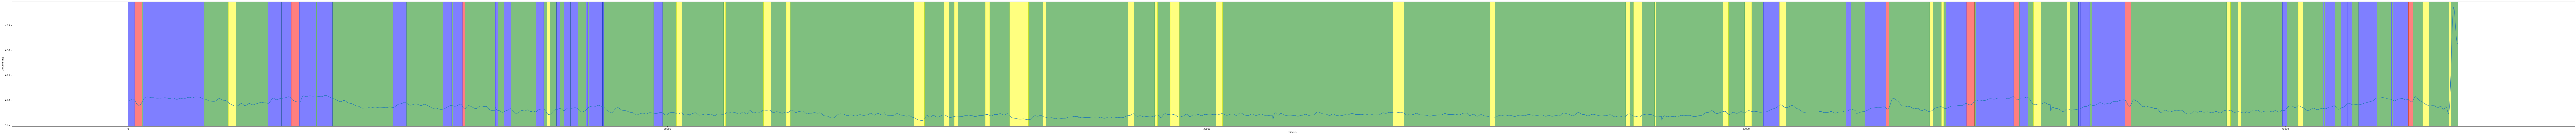

Trimmed Data


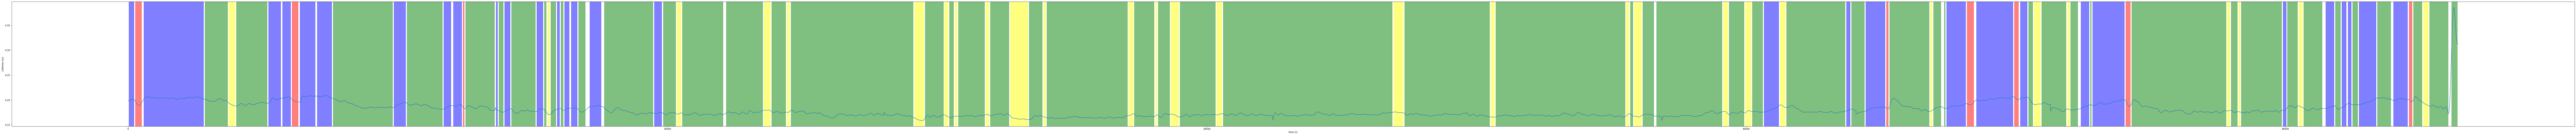

In [9]:
#Cell to run Analysis
results = runAnalysis(timePath, lifetimeDCPath, statesPath, trim, minLength)
results.to_csv((path + 'results/lft_emp_DC_epoch_analysis.csv'),index=False)

In [10]:
#Parameters
timePath = path + 'time.csv'
lifetimeACPath = path + 'lft_emp_AC.csv'
statesPath = path + 'states.csv'



#Data Returned as a df (results)
#Format:
#    State1                                               State 2...
#    calculated lifetime average    index   time window   calculated lifetime average    index   time

legend: 
{'state1': 'green', 'state2': 'blue', 'state3': 'red', 'state4': 'yellow'}
Raw Data


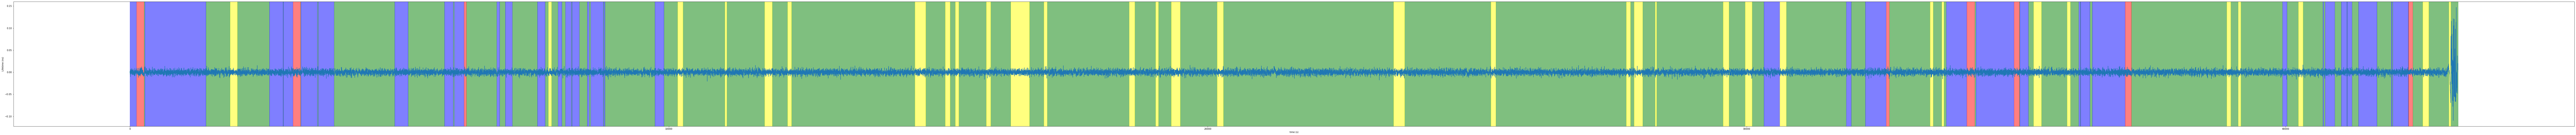

Trimmed Data


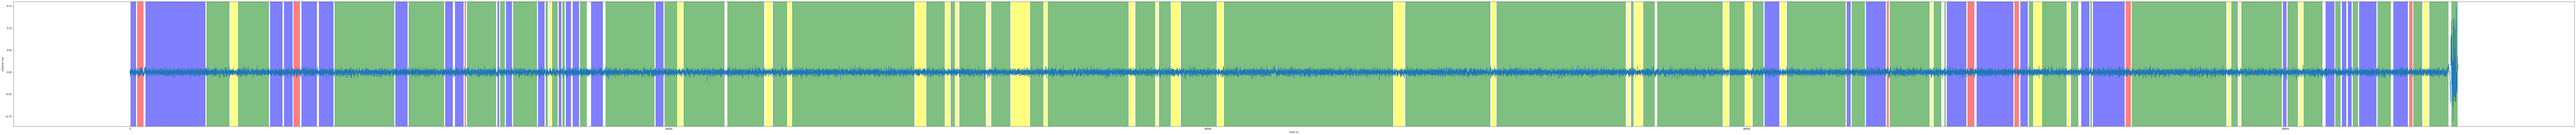

In [11]:
#Cell to run Analysis
results = runAnalysis(timePath, lifetimeACPath, statesPath, trim, minLength)
results.to_csv((path + 'results/lft_emp_AC_epoch_analysis.csv'),index=False)

In [12]:
#Parameters
timePath = path + 'time.csv'
intensityPath = path + 'intensity.csv'
statesPath = path + 'states.csv'



#Data Returned as a df (results)
#Format:
#    State1                                               State 2...
#    calculated lifetime average    index   time window   calculated lifetime average    index   time

legend: 
{'state1': 'green', 'state2': 'blue', 'state3': 'red', 'state4': 'yellow'}
Raw Data


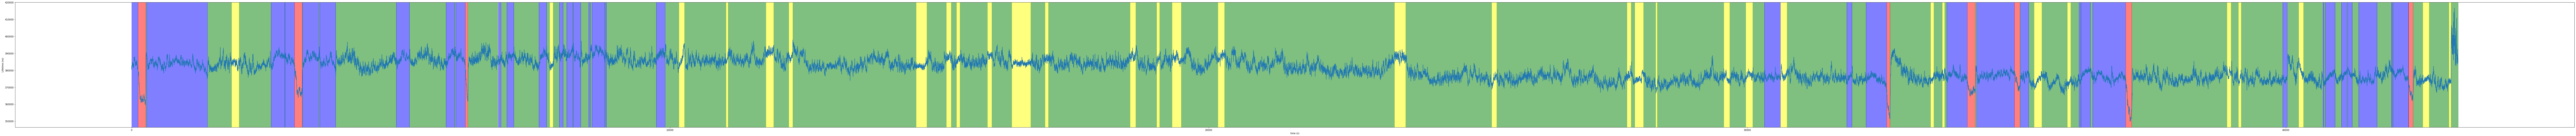

Trimmed Data


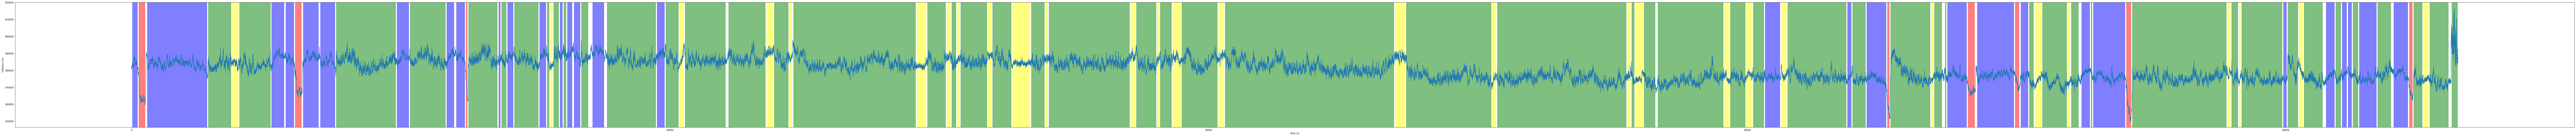

In [13]:
#Cell to run Analysis
results = runAnalysis(timePath, intensityPath, statesPath, trim, minLength)
results.to_csv((path + 'results/intensity_epoch_analysis.csv'),index=False)

In [14]:
#Parameters
timePath = path + 'time.csv'
intensityDCPath = path + 'intensity_DC.csv'
statesPath = path + 'states.csv'



#Data Returned as a df (results)
#Format:
#    State1                                               State 2...
#    calculated lifetime average    index   time window   calculated lifetime average    index   time

legend: 
{'state1': 'green', 'state2': 'blue', 'state3': 'red', 'state4': 'yellow'}
Raw Data


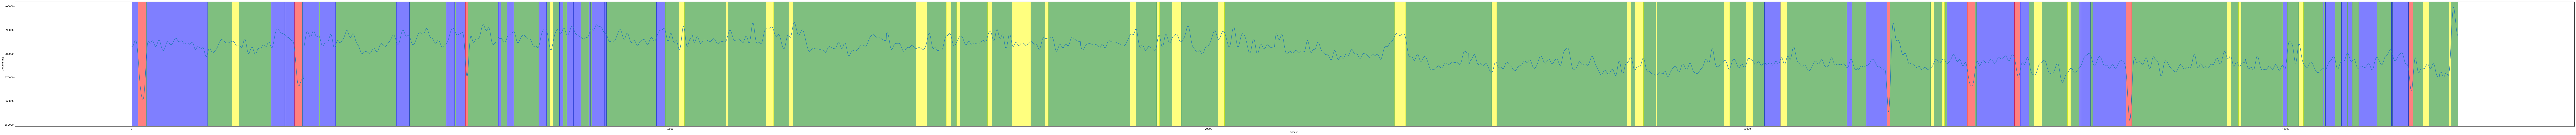

Trimmed Data


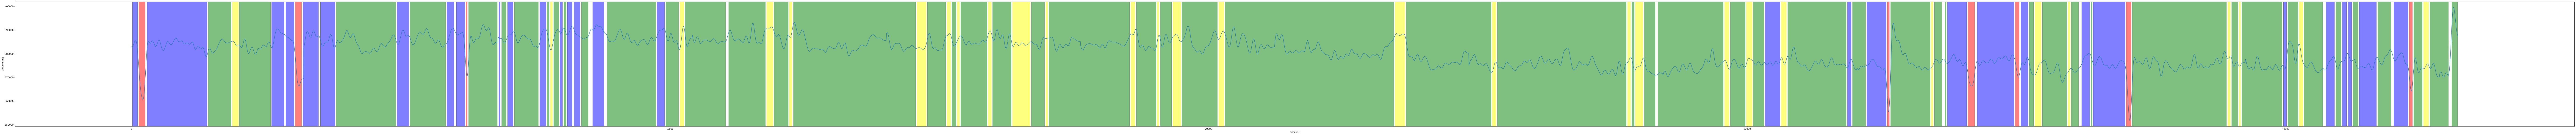

In [15]:
#Cell to run Analysis
results = runAnalysis(timePath, intensityDCPath, statesPath, trim, minLength)
results.to_csv((path + 'results/intensity_DC_epoch_analysis.csv'),index=False)

In [16]:
#Parameters
timePath = path + 'time.csv'
intensityACPath = path + 'intensity_AC.csv'
statesPath = path + 'states.csv'



#Data Returned as a df (results)
#Format:
#    State1                                               State 2...
#    calculated lifetime average    index   time window   calculated lifetime average    index   time

legend: 
{'state1': 'green', 'state2': 'blue', 'state3': 'red', 'state4': 'yellow'}
Raw Data


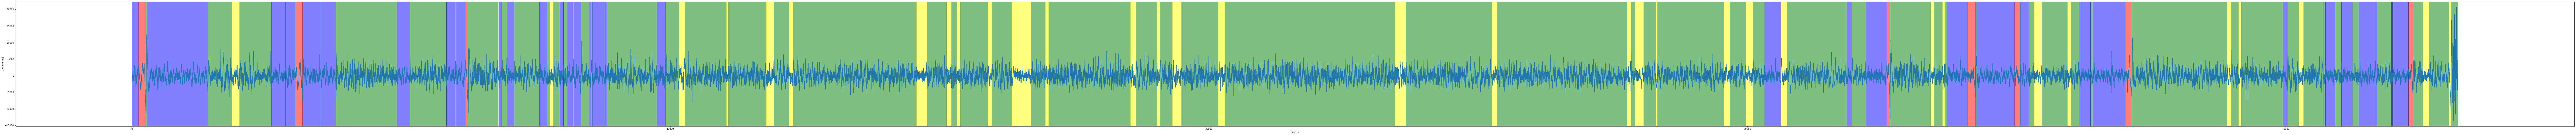

Trimmed Data


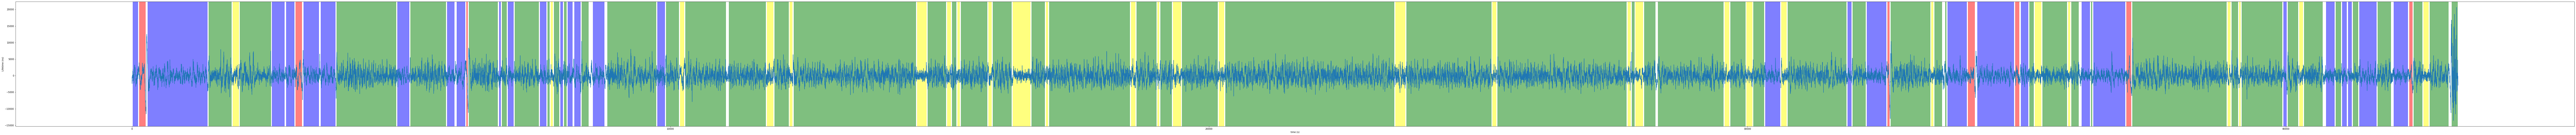

In [17]:
#Cell to run Analysis
results = runAnalysis(timePath, intensityACPath, statesPath, trim, minLength)
results.to_csv((path + 'results/intensity_AC_epoch_analysis.csv'),index=False)

In [18]:
#Parameters
timePath = path + 'time.csv'
LifetimeFitPath = path + 'lft_fit.csv'
statesPath = path + 'states.csv'



#Data Returned as a df (results)
#Format:
#    State1                                               State 2...
#    calculated lifetime average    index   time window   calculated lifetime average    index   time

legend: 
{'state1': 'green', 'state2': 'blue', 'state3': 'red', 'state4': 'yellow'}
Raw Data


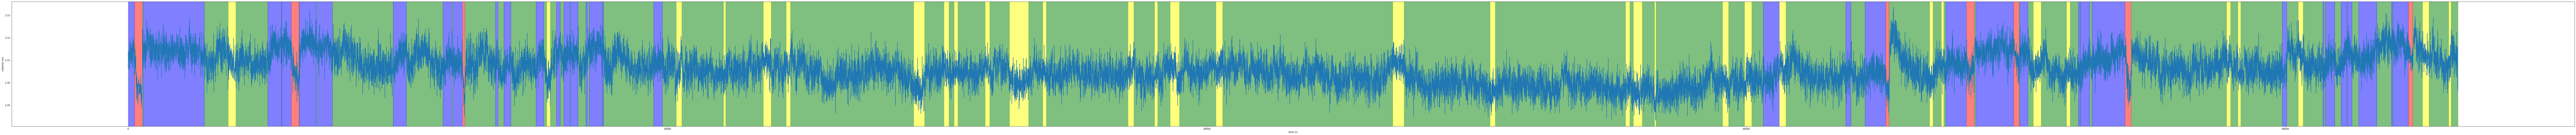

Trimmed Data


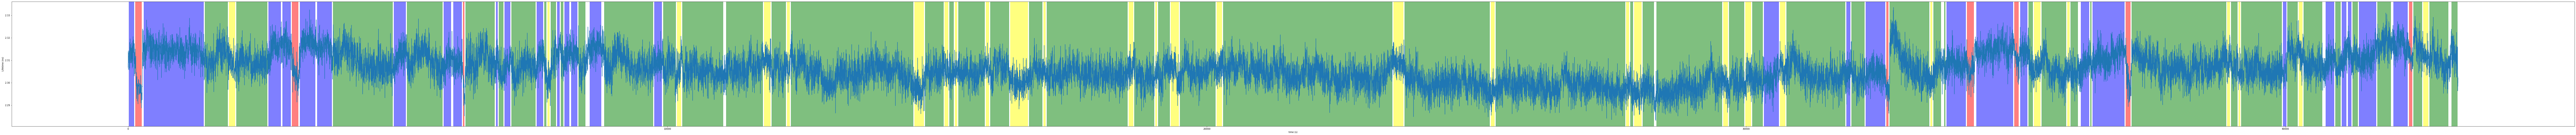

In [19]:
#Cell to run Analysis
results = runAnalysis(timePath, LifetimeFitPath, statesPath, trim, minLength)
results.to_csv((path + 'results/lft_fit_epoch_analysis.csv'),index=False)

In [20]:
#Parameters
timePath = path + 'time.csv'
LifetimeFitDCPath = path + 'lft_fit_DC.csv'
statesPath = path + 'states.csv'



#Data Returned as a df (results)
#Format:
#    State1                                               State 2...
#    calculated lifetime average    index   time window   calculated lifetime average    index   time

legend: 
{'state1': 'green', 'state2': 'blue', 'state3': 'red', 'state4': 'yellow'}
Raw Data


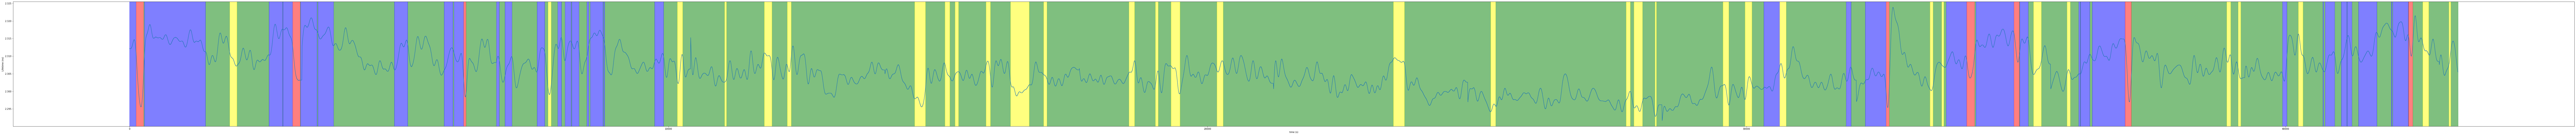

Trimmed Data


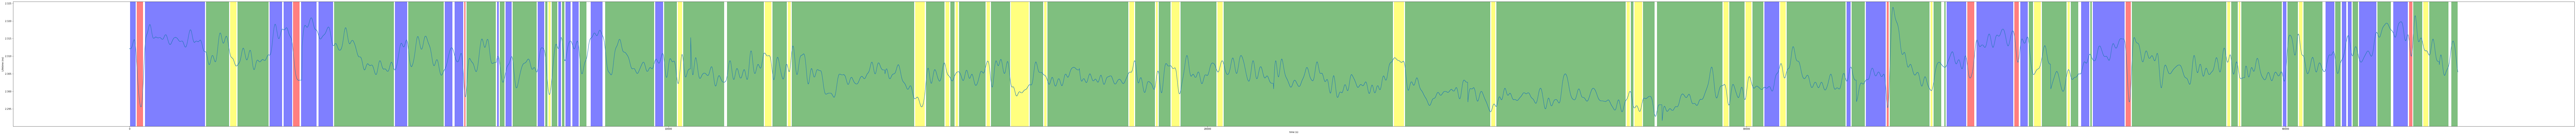

In [21]:
#Cell to run Analysis
results = runAnalysis(timePath, LifetimeFitDCPath, statesPath, trim, minLength)
results.to_csv((path + 'results/lft_fit_DC_epoch_analysis.csv'),index=False)

In [22]:
#Parameters
timePath = path + 'time.csv'
LifetimeFitACPath = path + 'lft_fit_AC.csv'
statesPath = path + 'states.csv'



#Data Returned as a df (results)
#Format:
#    State1                                               State 2...
#    calculated lifetime average    index   time window   calculated lifetime average    index   time

legend: 
{'state1': 'green', 'state2': 'blue', 'state3': 'red', 'state4': 'yellow'}
Raw Data


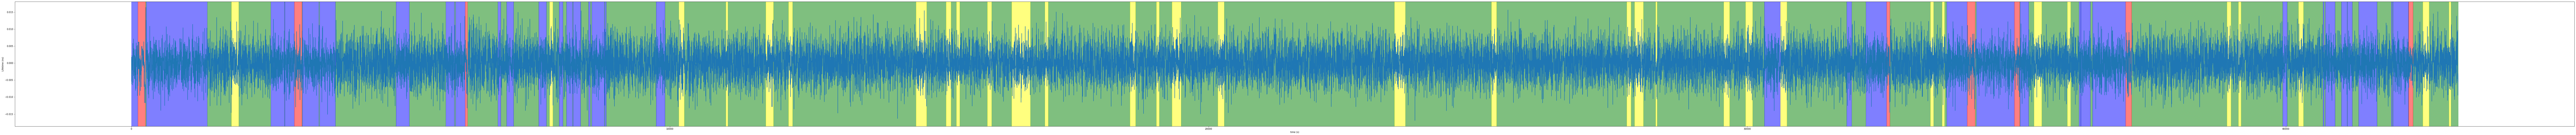

Trimmed Data


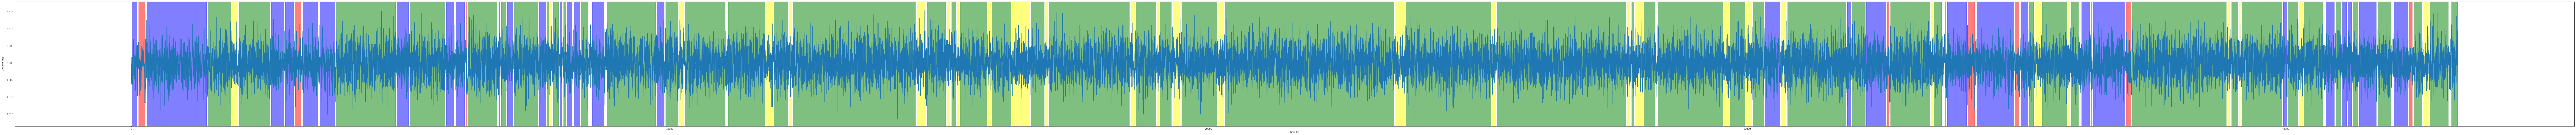

In [23]:
#Cell to run Analysis
results = runAnalysis(timePath, LifetimeFitACPath, statesPath, trim, minLength)
results.to_csv((path + 'results/lft_fit_AC_epoch_analysis.csv'),index=False)